This includes crawling Twitter data, as well as data cleaning, tagging, and final storage. 
And contains part of the visualization.

## Crawling Twitter data

In [2]:
import tweepy
import csv

access_token = "1126274230226694147-zCP7xsHfxUQBRdCCWZFg0UdQIwIyGP"
access_token_secret = "WITG7y0GOTGZ0SaIHWCj6iiNbiMO3SiKHgyIl62plOBkT"
consumer_key = "WXLp21bvEF5iPGWZVVEXnSoLc"
consumer_secret = "3tHHIsCrauC13OLKHAfpu764Ffn6gUTF1AkXaELH0PbLPiN6s4"

def get_tweets():
    """Crawling twitter data and storing it
    """
    global user_ids
    idx = 0
    while len(user_ids) >= 1:
        try:
            user_id = user_ids[idx]
            print('crawling user %s data...' % user_id)
            auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
            auth.set_access_token(access_token, access_token_secret)
            api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            tweets = []  # data to save
            new_tweets = api.user_timeline(user_id, count=500)
            tweets.extend(new_tweets)
            old = tweets[-1].id - 1
            while len(new_tweets) > 0:
                new_tweets = api.user_timeline(user_id=user_id, count=500, max_id=old)
                tweets.extend(new_tweets)
                old = tweets[-1].id - 1
                print('%s tweets downloaded' % (len(tweets)))

            out_tweets = [[tweet.text] for tweet in tweets]
            user_ids.remove(user_id)
            with open('./%s_tweets.csv' % user_id, 'w',encoding='utf-8') as file:
                writer = csv.writer(file)
                writer.writerows(out_tweets)
            print('saved data')
        except tweepy.TweepError as e:
            if e.reason=='Not authorized.':
                print('this user not authorized.')
                user_ids.remove(user_id)
                continue
            else:print(e)

In [3]:
# six users
# rihanna katyperry ladygaga theellenshow britneyspears  britneyspears 
user_ids = [14230524, 21447363, 21447363, 15846407, 16409683, 15485441]
get_tweets()
print('End.....')

crawling user 14230524 data...
397 tweets downloaded
596 tweets downloaded
792 tweets downloaded
985 tweets downloaded
1179 tweets downloaded
1377 tweets downloaded
1574 tweets downloaded
1768 tweets downloaded
1966 tweets downloaded
2161 tweets downloaded
2351 tweets downloaded
2548 tweets downloaded
2744 tweets downloaded
2928 tweets downloaded
3121 tweets downloaded
3129 tweets downloaded
3129 tweets downloaded
saved data
crawling user 21447363 data...
400 tweets downloaded
600 tweets downloaded
800 tweets downloaded
1000 tweets downloaded
1200 tweets downloaded
1399 tweets downloaded
1596 tweets downloaded
1793 tweets downloaded
1992 tweets downloaded
2191 tweets downloaded
2391 tweets downloaded
2591 tweets downloaded
2790 tweets downloaded
2990 tweets downloaded
3186 tweets downloaded
3218 tweets downloaded
3218 tweets downloaded
saved data
crawling user 21447363 data...
400 tweets downloaded
600 tweets downloaded
800 tweets downloaded
1000 tweets downloaded
1200 tweets downloade

## Data preprocessing

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# The file was renamed in advance
data1 = pd.read_csv('data/data1.csv', header=None, names=['tweet'])
data2 = pd.read_csv('data/data2.csv', header=None, names=['tweet'])
data3 = pd.read_csv('data/data3.csv', header=None, names=['tweet'])
data4 = pd.read_csv('data/data4.csv', header=None, names=['tweet'])
data5 = pd.read_csv('data/data5.csv', header=None, names=['tweet'])
data6 = pd.read_csv('data/data6.csv', header=None, names=['tweet'])
data = pd.concat([data1,data2,data3,data4,data5,data6]).reset_index(drop=True)
print(data.shape)
data.head()

(19229, 1)


,tweet
0,"#METGALA #METGAGA 4️⃣\r\n📸 Jamie McCarthy, Dim..."
1,#METGALA #METGAGA 3️⃣\r\n📸 John Shearer @Getty...
2,#METGALA #METGAGA 2️⃣\r\n📸 Dia Dipasupil @Gett...
3,#METGALA #METGAGA 1️⃣ https://t.co/CE4fBycUhX
4,#MetGala #Fashion #Camp #SusanSontag #NotesOnC...


In [6]:
def remove_pattern(input_txt, pattern):
    """clean the data use Regular expression"""
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt 

data['tweet'] = np.vectorize(remove_pattern)(data['tweet'], "@[\w]*")  # Delete @ username
data['tweet'] = np.vectorize(remove_pattern)(data['tweet'], "#[\w]*")  # Delete @ tag
data['tweet'] = np.vectorize(remove_pattern)(data['tweet'], "https://t[\w/.]*")  # Delete URL
data['tweet'] = np.vectorize(remove_pattern)(data['tweet'], "http://t[\w/.]*")  # Delete URL
data['tweet'] = np.vectorize(remove_pattern)(data['tweet'], "[\w]*…")  # Delete omitted words
data['tweet'] = data['tweet'].str.replace("’", "'")  # Replace a unified separator, eg. I'm I‘m
data['tweet'] = data['tweet'].str.replace("[^a-zA-Z'#]", " ")  # Remove symbols
data['tweet'] = data['tweet'].str.replace('  ', ' ')
data['tweet'] = data['tweet'].str.lower()  # Convert all words to lowercase
data['tweet'] = data['tweet'].str.strip()  # Remove spaces at both ends
data = data.drop_duplicates(subset='tweet')  # Deduplication
data.shape

(17593, 1)

In [7]:
data = data[data.tweet != '']  # Remove data with empty content
data.shape

(17592, 1)

In [8]:
# Remove words of short length
data['tidy_tweet'] = data['tweet'].map(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [9]:
data = data[data['tidy_tweet'] != '']  # Remove data with empty content
data.shape

(17367, 2)

In [10]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Remove stop words
# before this step，you should run code below at first
# import nltk
# nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
data['token'] = data['tidy_tweet'].map(lambda x: x.split())

def clean_stopword(List):
    return [x for x in List if x not in stop_words]

data['token'] = data['token'].map(clean_stopword)

In [11]:
from nltk.stem.porter import *

# Extract stem, eg. have, had ==> have
stemmer = PorterStemmer()
data['token'] = data['token'].map(lambda x: [stemmer.stem(i) for i in x]) # stemming

In [12]:
data['tweet'] = data['token'].map(lambda x: ' '.join(x))  # Connect words into sentences
data = data[data['tweet'] != '']  # Remove data with empty content
data.shape

(17269, 3)

In [13]:
def file_to_wordset(filename):
    ''' Converts a file with a word per line to a Python set '''
    words = set()
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            words.add(line.strip())
    return words

# Sentiment dictionary for tagging
positive_words = file_to_wordset('data/positive-words.txt')
negative_words = file_to_wordset('data/negative-words.txt')

In [14]:
# tagging
def tagging(data, positive_words, negative_words):
    predictions = []
    for line in data:
        pos_count, neg_count = 0, 0
        for word in line.strip().split():
            if word in positive_words:
                pos_count += 1
            elif word in negative_words:
                neg_count += 1
        if pos_count > neg_count: # positive
            prediction = 1 
        elif pos_count < neg_count: # negative
            prediction = 0
        else:
            prediction = 2  # Neutral
        predictions.append(prediction)
    return predictions

data['label'] = tagging(data['tweet'], positive_words, negative_words)

In [15]:
data = data[['label', 'tweet']][data['tweet'].str.len() > 30]  # Remove sentences shorter than 30

### Store the final file!!!

In [16]:
data.to_csv('data/data.csv', index=False)  # Store the final file!!!

## Visualization using word cloud images

You can see that some positive words appear very frequently in positive tweet.

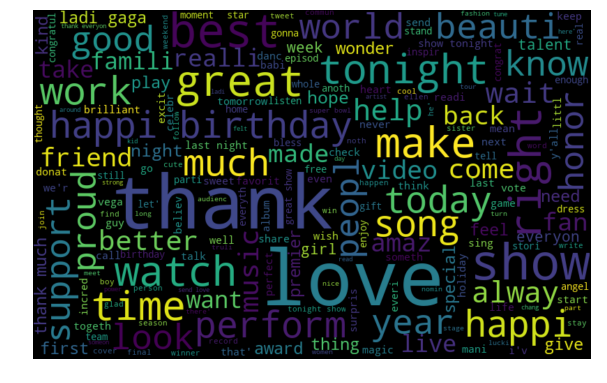

In [18]:
all_words = ' '.join([text for text in data['tweet'][data['label'] == 1]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

You can see some negative words, but because the Twitter data is not very good, depending on the user you get, the effect is not very obvious.

But you can still see some words. eg. miss, tonight, monster..

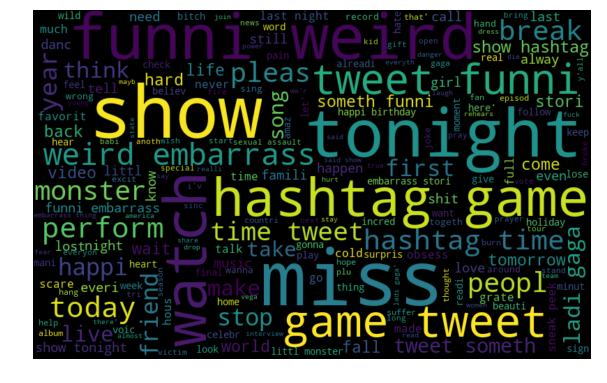

In [19]:
all_words = ' '.join([text for text in data['tweet'][data['label'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

You can see some neutral words, but because the Twitter data is not very good, depending on the user you get, the effect is not very obvious.

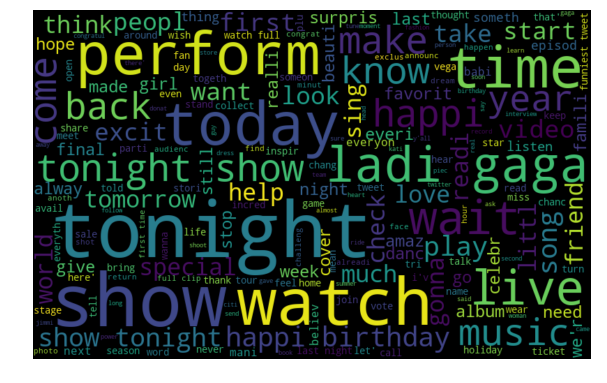

In [20]:
all_words = ' '.join([text for text in data['tweet'][data['label'] == 2]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

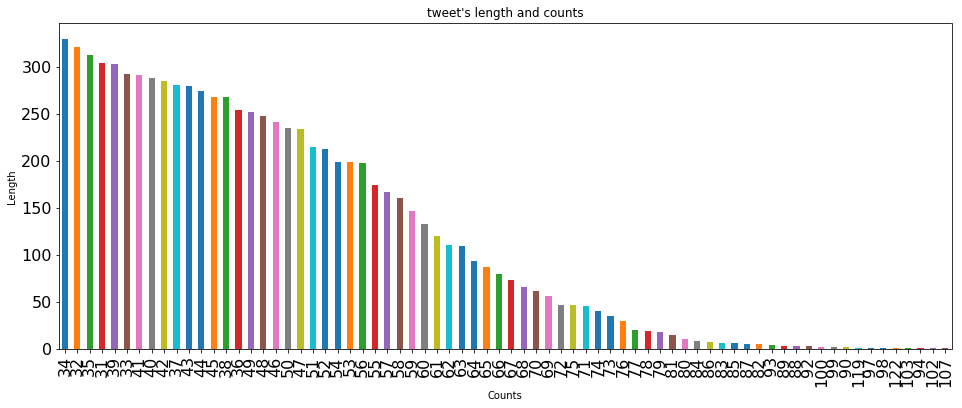

In [21]:
# Length distribution of all tweet
data['length'] = data['tweet'].map(len)
data['length'].value_counts().plot('bar', figsize=(16, 6),fontsize=16)
plt.title("tweet's length and counts")
plt.xlabel('Counts')
plt.ylabel('Length')
plt.show()